In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
from scipy.linalg import eigh
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.plotting import plot_decision_regions


df = pd.read_csv('/home/aaronpham5504/personalFolder/MSA/Project/MSA-Vstatis/Data/Stars.csv', encoding='ascii')
print(df.head())

   Temperature         L       R    A_M Color Spectral_Class  Type
0         3068  0.002400  0.1700  16.12   Red              M     0
1         3042  0.000500  0.1542  16.60   Red              M     0
2         2600  0.000300  0.1020  18.70   Red              M     0
3         2800  0.000200  0.1600  16.65   Red              M     0
4         1939  0.000138  0.1030  20.06   Red              M     0


In [2]:
from sklearn.preprocessing import StandardScaler

# Tách đặc trưng và nhãn
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Mã hóa cột phân loại nếu có
cat_features_list = X.select_dtypes(include=['object']).columns
X[cat_features_list] = X[cat_features_list].apply(LabelEncoder().fit_transform)

# Chuẩn hóa
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

X_scaled = X

# Gán lại dữ liệu đã chuẩn hóa vào DataFrame với tên cột ban đầu
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Thêm lại cột nhãn (chưa bị chuẩn hóa)
df_scaled['Type'] = y.values

# In bảng sau khi chuẩn hóa
print(df_scaled.head())


   Temperature         L       R    A_M  Color  Spectral_Class  Type
0         3068  0.002400  0.1700  16.12      8               5     0
1         3042  0.000500  0.1542  16.60      8               5     0
2         2600  0.000300  0.1020  18.70      8               5     0
3         2800  0.000200  0.1600  16.65      8               5     0
4         1939  0.000138  0.1030  20.06      8               5     0


## Data Preprocessing

In [3]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]
cat_features_list = X.select_dtypes(include=['object']).columns
X[cat_features_list] = X[cat_features_list].apply(LabelEncoder().fit_transform)

X, y = X.values, LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (180, 6)
X_test shape: (60, 6)
y_train shape: (180,)
y_test shape: (60,)


## Within-class Variance

In [4]:
def calculate_within_class_scatter(X, y, num_classes):
    n_features = X.shape[1]
    Sw = np.zeros((n_features, n_features))  # Initialize Sw

    for cls in range(num_classes):  # Iterate over each class
        X_cls = X[y == cls]  # Samples belonging to the current class
        if len(X_cls) > 0:
            mean_cls = np.mean(X_cls, axis=0)  # Mean vector of the class
            diff = X_cls - mean_cls  # Center the samples
            Sw += diff.T @ diff  # Accumulate scatter matrix

    return Sw

## Between Class Variance

In [5]:
def calculate_between_class_scatter(X, y, num_classes):
    n_features = X.shape[1]
    overall_mean = np.mean(X, axis=0)  # Overall mean vector
    Sb = np.zeros((n_features, n_features))  # Initialize Sb

    for cls in range(num_classes):  # Iterate over each class
        X_cls = X[y == cls]  # Samples belonging to the current class
        n_cls = len(X_cls)  # Number of samples in the class
        if n_cls > 0:
            mean_cls = np.mean(X_cls, axis=0)  # Mean vector of the class
            diff = (mean_cls - overall_mean).reshape(-1, 1)  # (mean_cls - overall_mean)
            Sb += n_cls * (diff @ diff.T)  # Accumulate scatter matrix

    return Sb

## LDA Objective Function

In [6]:
def lda_objective_function(W, SW, SB):
    WT_SW_W = np.dot(W.T, np.dot(SW, W))
    WT_SB_W = np.dot(W.T, np.dot(SB, W))

    # Kiểm tra xem WT_SW_W có khả nghịch không
    try:
        WT_SW_W_inv = np.linalg.inv(WT_SW_W)
    except np.linalg.LinAlgError:
        print("Ma trận WT_SW_W là suy biến, không thể tính nghịch đảo.")
        return -np.inf  # Trả về giá trị âm vô cùng để biểu thị trường hợp không hợp lệ

    objective_value = np.trace(np.dot(WT_SW_W_inv, WT_SB_W))
    return objective_value

## Optimized Problem

In [7]:
def solve_lda(X, y, num_classes, num_components):
    # Compute scatter matrices
    Sw = calculate_within_class_scatter(X, y, num_classes)
    Sb = calculate_between_class_scatter(X, y, num_classes)

    # Solve the generalized eigenvalue problem for Sb and Sw
    try:
        eigenvalues, eigenvectors = eigh(Sb, Sw)  # Use scipy.linalg.eigh for stability
    except np.linalg.LinAlgError as e:
        print(f"Error solving eigenvalue problem: {e}")
        return None

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select the top num_components eigenvectors
    W = eigenvectors[:, :num_components]
    return W

## Classification

In [8]:
def predict_lda(X, W, X_train, y_train):
    # Project the training data into the LDA space
    X_train_projected = X_train @ W

    # Compute class centroids in the LDA space
    classes = np.unique(y_train)
    centroids = np.array([X_train_projected[y_train == cls].mean(axis=0) 
                          for cls in classes])

    # Project the new data into the LDA space
    X_projected = X @ W

    # Assign each point to the nearest centroid
    distances = np.linalg.norm(X_projected[:, np.newaxis] - centroids, axis=2)
    predictions = classes[np.argmin(distances, axis=1)]

    return predictions

In [9]:
class CustomLDAClassifier:
    def __init__(self, W, X_train, y_train):
        self.W = W
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X):
        return predict_lda(X, self.W, self.X_train, self.y_train)

**Run on Stars Dataset** 

In [10]:
# Number of classes and components
num_classes = len(np.unique(y_train))
num_components = num_classes - 1  # Number of components to retain

# Solve LDA
W = solve_lda(X_train, y_train, num_classes, num_components)

# Project the training data
X_train_projected = X_train @ W

print(X_train.shape)
print(X_train_projected.shape)

# Predict on test data
lda_pred_res = predict_lda(X_test, W, X_train, y_train)

# Evaluate accuracy
lda_accuracy = accuracy_score(y_test, lda_pred_res)

print(f"LDA Accuracy: {lda_accuracy:.4f}")
print(f"Results: {lda_pred_res}")

(180, 6)
(180, 5)
LDA Accuracy: 1.0000
Results: [4 1 3 1 4 4 3 4 3 1 1 2 2 3 5 1 0 5 4 0 4 5 2 0 0 2 1 3 1 4 5 4 2 0 2 5 2
 5 0 3 3 4 3 1 4 1 4 0 5 5 0 3 5 1 3 3 5 3 5 4]


In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Đọc file CSV vào DataFrame
df_test = pd.read_csv('/home/aaronpham5504/personalFolder/MSA/Project/MSA-Vstatis/Data/Stars.csv', encoding='ascii')

# Xác định giá trị ở cột đầu tiên của hàng bạn muốn bỏ
# Dựa trên chuỗi bạn cung cấp, giá trị ở cột đầu tiên có thể là 'Type'
value_to_drop = 'Type'

# Tìm index của hàng chứa giá trị cần bỏ ở cột đầu tiên
index_to_drop = df_test[df_test.iloc[:, 0] == value_to_drop].index

# Bỏ hàng đó khỏi DataFrame
df_test = df_test.drop(index_to_drop)

# Reset index của DataFrame sau khi bỏ hàng (tùy chọn)
df_test = df_test.reset_index(drop=True)

# Tách đặc trưng và nhãn từ df_test sau khi đã bỏ hàng
X_test_dataset = df_test.iloc[:, :-1]
y_test_dataset = df_test.iloc[:, -1]

# Mã hóa cột phân loại nếu có
cat_features_list = X_test_dataset.select_dtypes(include=['object']).columns
if not cat_features_list.empty:
    X_test_dataset[cat_features_list] = X_test_dataset[cat_features_list].apply(LabelEncoder().fit_transform)

# In ra vài dòng đầu của X_test_dataset để kiểm tra
print("Vài dòng đầu của X_test_dataset sau khi bỏ hàng:")
print(X_test_dataset.head())

print("\nVài dòng đầu của y_test_dataset sau khi bỏ hàng:")
print(y_test_dataset.head())

Vài dòng đầu của X_test_dataset sau khi bỏ hàng:
   Temperature         L       R    A_M  Color  Spectral_Class
0         3068  0.002400  0.1700  16.12      8               5
1         3042  0.000500  0.1542  16.60      8               5
2         2600  0.000300  0.1020  18.70      8               5
3         2800  0.000200  0.1600  16.65      8               5
4         1939  0.000138  0.1030  20.06      8               5

Vài dòng đầu của y_test_dataset sau khi bỏ hàng:
0    0
1    0
2    0
3    0
4    0
Name: Type, dtype: int64


**Predictions visualization**

In [12]:
# Scatter plot of the data before applying LDA
def plot_raw_data(X, y, feature_indexes, class_labels=None):
    """
    Plot the raw data using the selected features to visualize class overlap.

    Args:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): Target labels.
        feature_indexes (list): List of feature indexes to plot (2D plot).
        class_labels (list): Optional list of class labels for the legend.
    """
    plt.figure(figsize=(8, 6))
    
    # Extract the selected features
    X_selected = X[:, feature_indexes]
    feature_x, feature_y = feature_indexes
    
    # Scatter plot for each class
    classes = np.unique(y)
    for cls in classes:
        plt.scatter(
            X_selected[y == cls, 0],  # Feature 1
            X_selected[y == cls, 1],  # Feature 2
            label=f"Class {cls}" if class_labels is None else class_labels[cls],
            alpha=0.7
        )
    
    # Add labels and title
    plt.xlabel(f"Feature {feature_x}")
    plt.ylabel(f"Feature {feature_y}")
    plt.title("Raw Data Visualization (Before LDA)")
    plt.legend()
    plt.grid(True)
    plt.show()

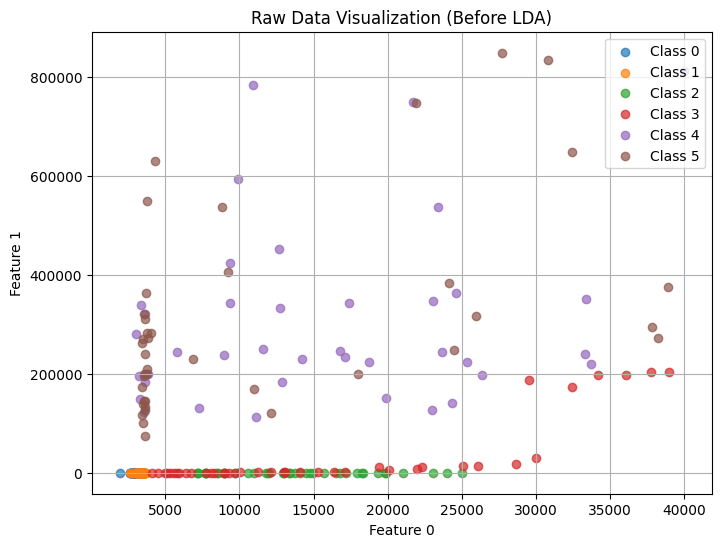

In [13]:
feature_indexes = [0, 1]  # Example feature indexes to plot
plot_raw_data(X,y, feature_indexes)

In [14]:
# Step 1: Compute the projection matrix
num_classes = len(np.unique(y_train))
# print(f"Number of classes: {num_classes}")
num_components = num_classes - 1
# print(f"Number of components: {num_components}")
W = solve_lda(X_train[:, feature_indexes], y_train, num_classes, num_components)


print(W)

# # Step 2: Create a custom classifier using the projection matrix
# custom_clf = CustomLDAClassifier(W, X_train[:, feature_indexes], y_train)

# # Step 3: Visualize the decision regions
# plt.title('LDA surface with original features')
# plot_decision_regions(X=X[:, feature_indexes], y=y, clf=custom_clf)
# plt.xlabel(f"Feature {feature_indeWxes[0]}")
# plt.ylabel(f"Feature {feature_indexes[1]}")
# plt.show()

[[-4.33912485e-06 -1.01772132e-05]
 [ 8.35026816e-07  2.69509492e-08]]


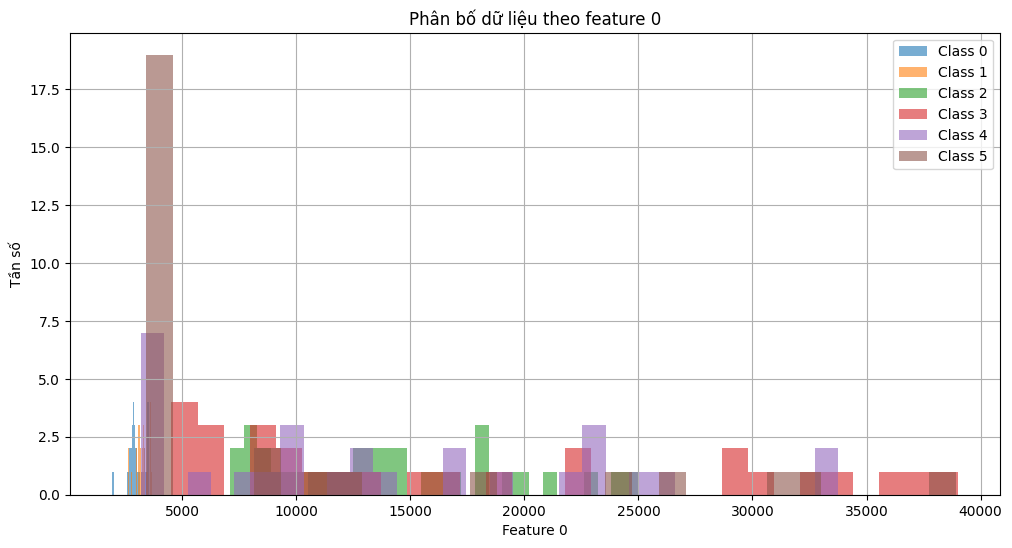

In [15]:
plt.figure(figsize=(12, 6))

# Duyệt từng lớp (0 -> 5) và vẽ histogram
for cls in range(6):
    plt.hist(
        X_train[y_train == cls][:, 0],  # Feature 1
        bins=30,
        alpha=0.6,
        label=f"Class {cls}"
    )

plt.title("Phân bố dữ liệu theo feature " + str(0))
plt.xlabel(f"Feature {feature_indexes[0]}")
plt.ylabel("Tần số")
plt.legend()
plt.grid(True)
plt.show()

(6, 5)
(240, 5)
(2, 2)


/home/aaronpham5504/personalFolder/MSA/Project/MSA-Vstatis/venv/lib/python3.12/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<Axes: title={'center': 'LDA surface with transformed features'}>

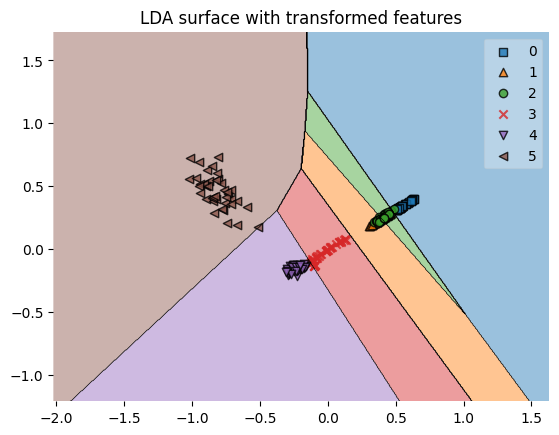

In [16]:
feature_indexes = [0, 1]
# sk_lda2 = LinearDiscriminantAnalysis(solver='eigen')
#X_lda = sk_lda2.fit(X, y).transform(X)
W = solve_lda(X, y, num_classes, num_components)
X_lda = X @ W
print(W.shape)
print(X_lda.shape)

X_lda = X_lda[:, feature_indexes]
X_lda_train, X_lda_test, y_train, y_test = train_test_split(X_lda, y, random_state=0)

#sk_lda2.fit(X_lda_train, y_train)
W2 = solve_lda(X_lda_train, y_train, num_classes, num_components)

print(W2.shape)

custom_clf = CustomLDAClassifier(W2, X_lda_train, y_train)

plt.title('LDA surface with transformed features')
plot_decision_regions(X=X_lda, y=y, clf=custom_clf)

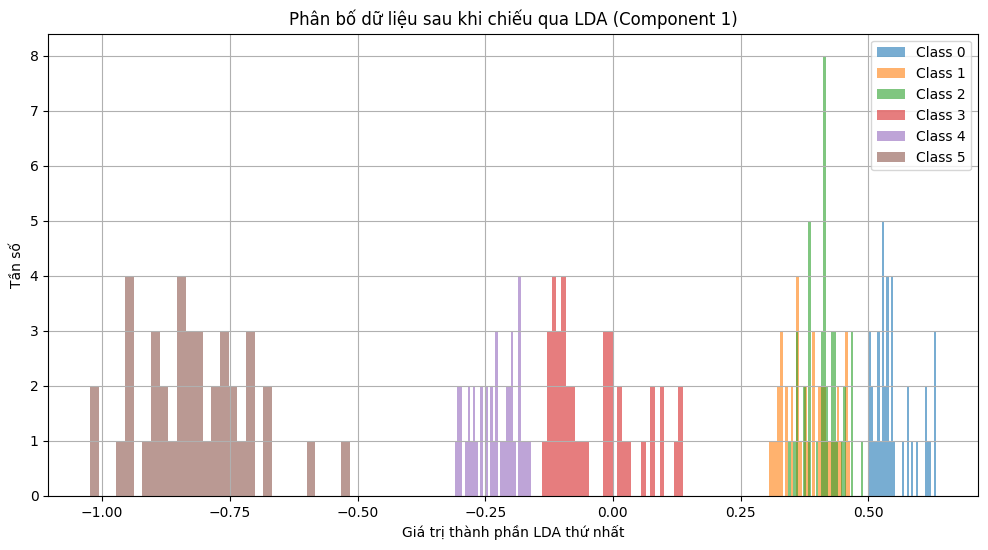

In [17]:
X_lda = X @ W  # Biến đổi dữ liệu gốc sang không gian LDA
plt.figure(figsize=(12, 6))

for cls in range(6):
    plt.hist(
        X_lda[y == cls][:, 0],  # LDA component 1
        bins=30,
        alpha=0.6,
        label=f"Class {cls}"
    )
    
plt.title("Phân bố dữ liệu sau khi chiếu qua LDA (Component 1)")
plt.xlabel("Giá trị thành phần LDA thứ nhất")
plt.ylabel("Tần số")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import pandas as pd
import numpy as np


def create_test_data(num_samples_per_class=10):
    """
    Tạo bộ dữ liệu kiểm thử mẫu cho bài toán phân loại sao.

    Args:
        num_samples_per_class (int): Số lượng mẫu tạo cho mỗi lớp.
    Returns:
        pandas.DataFrame: Bộ dữ liệu kiểm thử mẫu.
    """
    test_data = []
    np.random.seed(42)  # Để đảm bảo tính tái lặp

    for class_type in range(6):
        for _ in range(num_samples_per_class):
            sample = {}
            sample["Type"] = class_type

            # Tạo giá trị ngẫu nhiên cho từng feature dựa trên lớp (điều chỉnh khoảng giá trị)
            if class_type == 0:  # Red Dwarf (M)
                sample["Temperature"] = np.random.uniform(2500, 4000)
                sample["L"] = np.random.uniform(0.0001, 0.01)
                sample["R"] = np.random.uniform(0.05, 0.2)
                sample["A_M"] = np.random.uniform(16, 20)
                sample["Color"] = np.random.choice(["Red"])
                sample["Spectral_Class"] = np.random.choice(["M"])
            elif class_type == 1:  # Red Giant (M)
                sample["Temperature"] = np.random.uniform(2500, 4000)
                sample["L"] = np.random.uniform(0.01, 0.1)
                sample["R"] = np.random.uniform(0.2, 0.8)
                sample["A_M"] = np.random.uniform(10, 15)
                sample["Color"] = np.random.choice(["Red"])
                sample["Spectral_Class"] = np.random.choice(["M"])
            elif class_type == 2:  # White Dwarf (A, F, B)
                sample["Temperature"] = np.random.uniform(7000, 25000)
                sample["L"] = np.random.uniform(0.00001, 0.02)
                sample["R"] = np.random.uniform(0.005, 0.02)
                sample["A_M"] = np.random.uniform(11, 15)
                sample["Color"] = np.random.choice(
                    [
                        "White",
                        "Blue White",
                        "Yellowish White",
                        "Pale yellow orange",
                        "Blue white",
                    ]
                )
                sample["Spectral_Class"] = np.random.choice(["A", "F", "B"])
            elif class_type == 3:  # Main Sequence (O, B, A, F, K)
                sample["Temperature"] = np.random.uniform(5000, 40000)
                sample["L"] = np.random.uniform(0.1, 100000)
                sample["R"] = np.random.uniform(0.5, 10)
                sample["A_M"] = np.random.uniform(-5, 5)
                sample["Color"] = np.random.choice(
                    [
                        "Blue",
                        "Blue-white",
                        "Whitish",
                        "yellow-white",
                        "Yellowish",
                        "Orange-Red",
                    ]
                )
                sample["Spectral_Class"] = np.random.choice(["O", "B", "A", "F", "K"])
            elif class_type == 4:  # Supergiant (M, O, B)
                sample["Temperature"] = np.random.uniform(3000, 40000)
                sample["L"] = np.random.uniform(100000, 1000000)
                sample["R"] = np.random.uniform(10, 100)
                sample["A_M"] = np.random.uniform(-8, -4)
                sample["Color"] = np.random.choice(["Red", "Blue"])
                sample["Spectral_Class"] = np.random.choice(["M", "O", "B"])
            elif class_type == 5:  # Hypergiant (M, K, G, B, O)
                sample["Temperature"] = np.random.uniform(3000, 40000)
                sample["L"] = np.random.uniform(100000, 1000000)
                sample["R"] = np.random.uniform(500, 2000)
                sample["A_M"] = np.random.uniform(-12, -7)
                sample["Color"] = np.random.choice(["Red", "Orange", "Blue", "White"])
                sample["Spectral_Class"] = np.random.choice(["M", "K", "G", "B", "O"])

            test_data.append(sample)

    return pd.DataFrame(test_data)


# Tạo bộ dữ liệu kiểm thử với 15 mẫu cho mỗi lớp
test_df = create_test_data(num_samples_per_class=15)
print(test_df.head())
print(test_df["Type"].value_counts().sort_index())


   Type  Temperature         L         R        A_M Color Spectral_Class
0     0  3061.810178  0.009512  0.159799  18.394634   Red              M
1     0  2734.027961  0.001644  0.058713  19.464705   Red              M
2     0  3401.672518  0.007110  0.053088  19.879639   Red              M
3     0  3748.663961  0.002202  0.077274  16.733618   Red              M
4     0  2956.363364  0.005295  0.114792  17.164917   Red              M
Type
0    15
1    15
2    15
3    15
4    15
5    15
Name: count, dtype: int64
